# UIUC Grid Demand: Wind Power + Solar Elevation Angle

This notebook uses an Echo State Network(ESN) (from pyESN) to predict the Wind Power at the University of Illinois.
Rather than one input, there are two inputs: Wind Power and Solar Elevation Angle. 
The following items are included:

1. An initial demonstration of the ESN with a 72-hour prediction.
2. Grid optimization over spectral radius and noise
3. Grid optimization over reservoir size and sparsity
4. Demonstrate the effect of training length on accuracy.
5. A final demonstration of the ESN with optimized hyper-parameters.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, "/home/dotson/research/cairo")


# custom libraries
from tools import MSE, esn_prediction, param_string, optimal_values
from optimizers import grid_optimizer
from sunrise import generate_elevation_series
from pyESN.pyESN import ESN

In [2]:
# import demand data
dataframe = pd.read_csv("../data/railsplitter_data.csv", usecols=['Time','MWh'])
windpower = np.array(dataframe.MWh).astype('float64')

# normalize
norm = np.linalg.norm(windpower)
# norm = np.max(windpower)
windpower_norm = windpower/norm

In [3]:
lat = 40.18
lon = -89.24
time_range = pd.date_range(start='11/1/2016', end='7/1/2019', freq='h')[:len(windpower)]
elevation = generate_elevation_series(time_range, lat=lat, lon=lon, timestamps=True)
norm_a = np.linalg.norm(elevation)
# norm_a = np.max(elevation)
angles_norm = elevation/norm_a
print(f"Norm of elevation angles: {norm_a}")
print(f"Norm of wind power: {norm}")

Norm of elevation angles: 5528.904286307141
Norm of wind power: 608.6097404642815


## Format the Input Data

In [4]:
params = {'n_reservoir':2000, 
          'sparsity':0.03, 
          'rand_seed':85, 
          'rho':1.3, 
          'noise':0.0001, 
          'future':72, 
          'window':72, 
          'trainlen':17600}

rand_seeds = [85, 21, 22, 30, 122, 5, 79]

In [5]:
X_in = np.concatenate([[windpower_norm, angles_norm]], axis=1)
    
print(f"Shape of X_in is {X_in.shape}")

Shape of X_in is (2, 23328)


In [6]:
futureTotal = params['future']
time_range = np.array(dataframe.Time)
hour_range = np.arange(0, len(time_range), 1)

In [7]:
tic = time.perf_counter()

opt_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 46.77 seconds
This simulation took 0.78 minutes


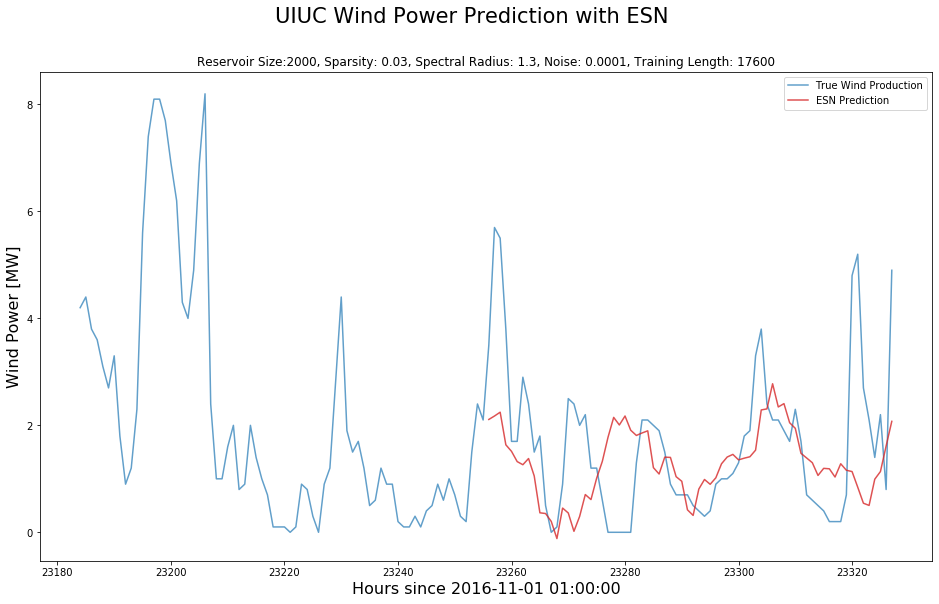

In [8]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("Wind Power [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*opt_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### Check other reservoir sizes for fun

In [9]:
N = len(rand_seeds)
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 306.94 seconds
This simulation took 5.12 minutes


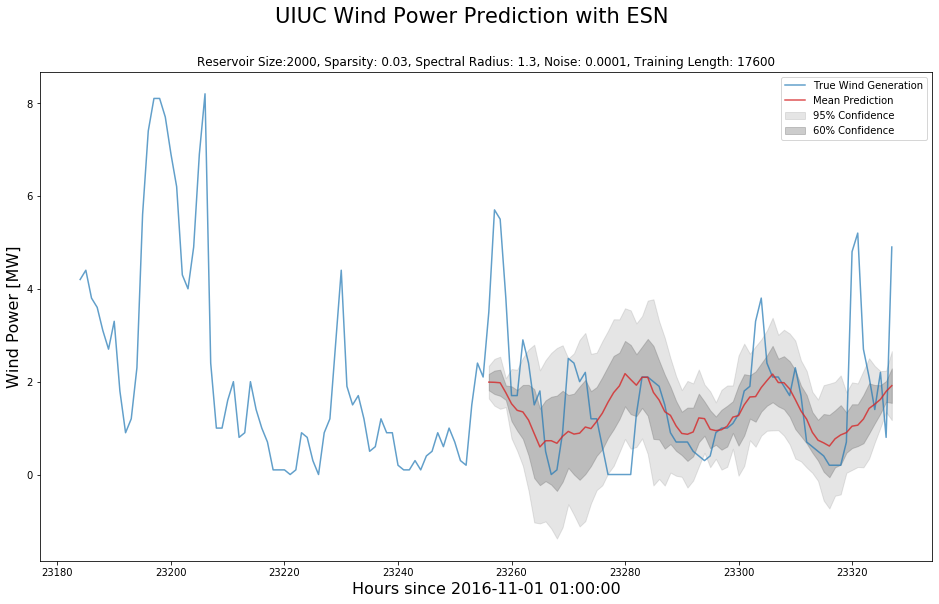

In [10]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("Wind Power [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Generation", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
         label='Mean Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + 2 * std_prediction),
                 norm*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + std_prediction),
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()

### Check even larger reservoirs

In [15]:
params['n_reservoir'] = 7000
params['sparsity'] = 0.03

tic = time.perf_counter()

opt_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 615.80 seconds
This simulation took 10.26 minutes


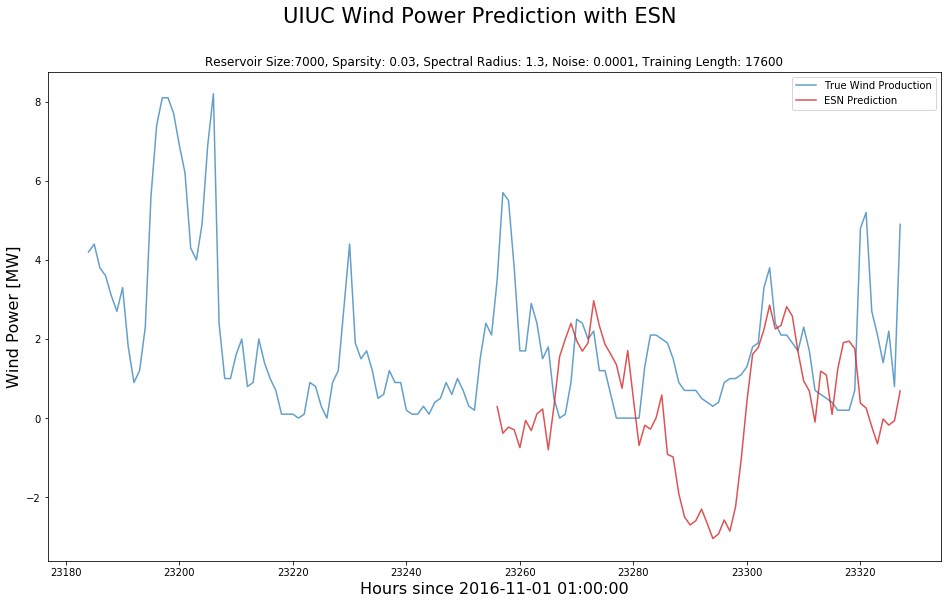

In [16]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("Wind Power [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*opt_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

In [17]:
N = len(rand_seeds)
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 4258.67 seconds
This simulation took 70.98 minutes


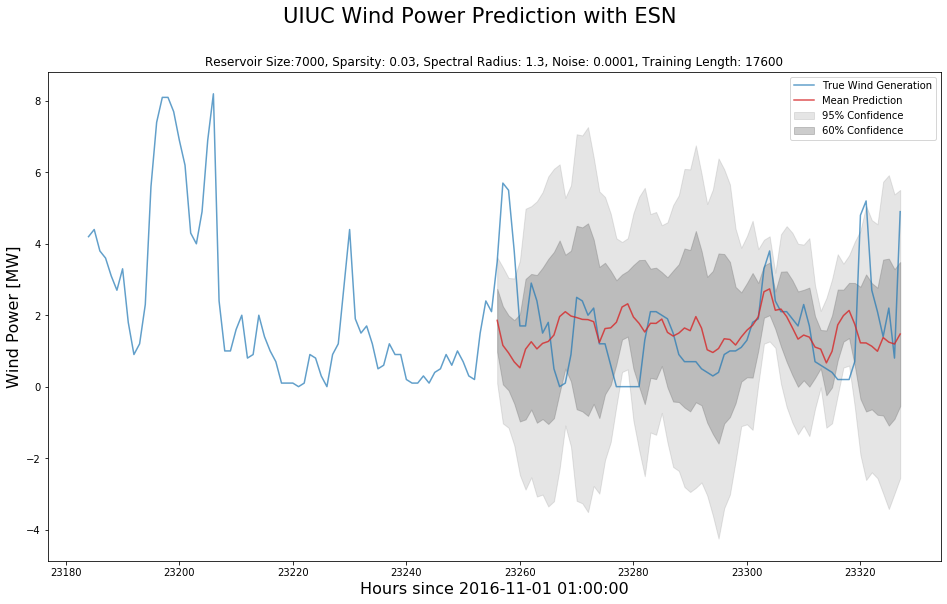

In [18]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("Wind Power [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Generation", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
         label='Mean Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + 2 * std_prediction),
                 norm*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + std_prediction),
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()